In [1]:
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

#sci-kit learn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

#text/NLP 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

from sklearn.metrics import (confusion_matrix,accuracy_score, roc_auc_score, recall_score,
    precision_score, roc_curve, auc)
from sklearn.metrics import ConfusionMatrixDisplay


#for oversampling 
from imblearn.over_sampling import RandomOverSampler

In [4]:
df_lyrics = pd.read_csv('lyrics_all_combined.csv')
df_lyrics.head(3)

df_lyrics=df_lyrics.dropna(subset=['lyrics'])

df_lyrics.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11978 entries, 0 to 11977
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   artist_name   11978 non-null  object 
 1   track_name    11978 non-null  object 
 2   release_date  11978 non-null  int64  
 3   genre         11978 non-null  object 
 4   lyrics        11978 non-null  object 
 5   len           11978 non-null  int64  
 6   valence       11978 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 748.6+ KB


In [6]:
import pandas as pd
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

df_lyrics['lyrics'] = df_lyrics['lyrics'].apply(str)

# Convert all string of lyrics to lowercase.
df_lyrics['lyrics'] = df_lyrics['lyrics'].str.lower()

# Tokenize text from lyrics. 
df_lyrics['tokenized'] = df_lyrics['lyrics'].apply(word_tokenize)

# Remove punctuations.
punc_marks = list(string.punctuation)
df_lyrics['tokenized'] = df_lyrics['tokenized'].apply(lambda x: [word for word in x if word not in punc_marks])
                                                                       
# Display smaple data. 
df_lyrics.sample(10)

,artist_name,track_name,release_date,genre,lyrics,len,valence,tokenized
10777,guns n' roses,mr. brownstone,1987,rock,seven worry worry waste fuck time usually star...,93,0.518755,"[seven, worry, worry, waste, fuck, time, usual..."
6359,kid cudi,day 'n' nite (nightmare),2009,pop,night toss turn stress mind mind look peace at...,172,0.788747,"[night, toss, turn, stress, mind, mind, look, ..."
10076,anthrax,i'm the man,1987,rock,ohoooohhhhh yeah anthrax shit care write hit s...,160,0.478566,"[ohoooohhhhh, yeah, anthrax, shit, care, write..."
11561,joy division,colony,1980,rock,help hint anesthesia sound break home meet lay...,70,0.808326,"[help, hint, anesthesia, sound, break, home, m..."
7615,gary lewis & the playboys,dream lover,1965,pop,night pray dream lover come girl hold arm know...,106,0.868096,"[night, pray, dream, lover, come, girl, hold, ..."
7887,say anything,a walk through hell,2005,pop,swim swim ocean swim float dark bless walk wat...,99,0.567189,"[swim, swim, ocean, swim, float, dark, bless, ..."
7496,chubby checker,the watusi,1961,pop,everybody yeah yeah yeah yeah yeah yeah yeah y...,110,0.848516,"[everybody, yeah, yeah, yeah, yeah, yeah, yeah..."
9225,kameleba,si no somos felices,2015,reggae,want care heart room need know cause night tel...,92,0.757832,"[want, care, heart, room, need, know, cause, n..."
1866,jethro tull,sweet dream,1978,blues,hear call sweet dream hear daddy warn go thing...,64,0.378607,"[hear, call, sweet, dream, hear, daddy, warn, ..."
4698,hieroglyphics,casual,1998,jazz,welllllll alright hold tight rhyme bright bold...,113,0.297197,"[welllllll, alright, hold, tight, rhyme, brigh..."


In [7]:
stopwords = nltk.corpus.stopwords.words('english')

# Add personalised list of stop words.
stopwords.extend(["'m", "'s", "'d", "hi", "im", "wa", "n't",'wan','na','u','gon' ,'ahah','ayo',"'get", "'ll", "'re", "'ve", "get", "still", "mmm", "ooh", "oooh", "yah", "yeh","mmm", "hmm","i'm"])

# Remove the stop words from the dataset. 
df_lyrics['cleaned_stopwords'] = df_lyrics['tokenized'].apply(lambda x: [word for word in x if word not in stopwords])

# Check first few rows. 
df_lyrics.head(3)

,artist_name,track_name,release_date,genre,lyrics,len,valence,tokenized,cleaned_stopwords
0,santana,wham!,1978,blues,cold chamber smoke kush gettin higher plane sw...,198,0.857791,"[cold, chamber, smoke, kush, gettin, higher, p...","[cold, chamber, smoke, kush, gettin, higher, p..."
1,marvin sease,show me what you got,1991,blues,public service announcement weezy baby best ra...,198,0.794930,"[public, service, announcement, weezy, baby, b...","[public, service, announcement, weezy, baby, b..."
2,the robert cray band,1040 blues,1993,blues,gotta rapper today forget fuck smokin brain ce...,198,0.613561,"[got, ta, rapper, today, forget, fuck, smokin,...","[got, ta, rapper, today, forget, fuck, smokin,..."


In [8]:
def determine_wordnet_speech(word_tag):
    if word_tag.startswith('J'):
        return wordnet.ADJ
    elif word_tag.startswith('V'):
        return wordnet.VERB
    elif word_tag.startswith('N'):
        return wordnet.NOUN
    elif word_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Add part of speech tags.
df_lyrics['pos_tags'] = df_lyrics['cleaned_stopwords'].apply(nltk.tag.pos_tag)

# Function to get part of speech in WordNet format.
df_lyrics['pos_tags'] = df_lyrics['pos_tags'].apply(lambda x: [(word, determine_wordnet_speech(pos_tag)) for (word, pos_tag) in x])

word_lemmatizer = WordNetLemmatizer()
df_lyrics['lyrics_lemmatized'] = df_lyrics['pos_tags'].apply(lambda x: [word_lemmatizer.lemmatize(word, tag) for word, tag in x])

# Convert list to string datatype. 
df_lyrics['lyrics_lemmatized'] = [' '.join(map(str,l)) for l in df_lyrics['lyrics_lemmatized']]

# Check few rows.
df_lyrics.head(3)

,artist_name,track_name,release_date,genre,lyrics,len,valence,tokenized,cleaned_stopwords,pos_tags,lyrics_lemmatized
0,santana,wham!,1978,blues,cold chamber smoke kush gettin higher plane sw...,198,0.857791,"[cold, chamber, smoke, kush, gettin, higher, p...","[cold, chamber, smoke, kush, gettin, higher, p...","[(cold, a), (chamber, n), (smoke, v), (kush, n...",cold chamber smoke kush gettin high plane swan...
1,marvin sease,show me what you got,1991,blues,public service announcement weezy baby best ra...,198,0.794930,"[public, service, announcement, weezy, baby, b...","[public, service, announcement, weezy, baby, b...","[(public, a), (service, n), (announcement, n),...",public service announcement weezy baby best ra...
2,the robert cray band,1040 blues,1993,blues,gotta rapper today forget fuck smokin brain ce...,198,0.613561,"[got, ta, rapper, today, forget, fuck, smokin,...","[got, ta, rapper, today, forget, fuck, smokin,...","[(got, v), (ta, a), (rapper, n), (today, n), (...",get ta rapper today forget fuck smokin brain c...


In [9]:
df_lyrics.head()

,artist_name,track_name,release_date,genre,lyrics,len,valence,tokenized,cleaned_stopwords,pos_tags,lyrics_lemmatized
0,santana,wham!,1978,blues,cold chamber smoke kush gettin higher plane sw...,198,0.857791,"[cold, chamber, smoke, kush, gettin, higher, p...","[cold, chamber, smoke, kush, gettin, higher, p...","[(cold, a), (chamber, n), (smoke, v), (kush, n...",cold chamber smoke kush gettin high plane swan...
1,marvin sease,show me what you got,1991,blues,public service announcement weezy baby best ra...,198,0.794930,"[public, service, announcement, weezy, baby, b...","[public, service, announcement, weezy, baby, b...","[(public, a), (service, n), (announcement, n),...",public service announcement weezy baby best ra...
2,the robert cray band,1040 blues,1993,blues,gotta rapper today forget fuck smokin brain ce...,198,0.613561,"[got, ta, rapper, today, forget, fuck, smokin,...","[got, ta, rapper, today, forget, fuck, smokin,...","[(got, v), (ta, a), (rapper, n), (today, n), (...",get ta rapper today forget fuck smokin brain c...
3,carl sims,it's just a party,2004,blues,girls knock ghetto ballin real thugs unngghhhh...,198,0.705276,"[girls, knock, ghetto, ballin, real, thugs, un...","[girls, knock, ghetto, ballin, real, thugs, un...","[(girls, n), (knock, v), (ghetto, n), (ballin,...",girl knock ghetto ballin real thug unngghhhhhh...
4,rufus thomas,sixty minute man,2011,blues,diddle devil yabba double walk feel body feel ...,198,0.651690,"[diddle, devil, yabba, double, walk, feel, bod...","[diddle, devil, yabba, double, walk, feel, bod...","[(diddle, a), (devil, n), (yabba, n), (double,...",diddle devil yabba double walk feel body feel ...


In [29]:
X = df_lyrics['lyrics_lemmatized']
y = df_lyrics['genre']

In [33]:
X.head()

0    cold chamber smoke kush gettin high plane swan...
1    public service announcement weezy baby best ra...
2    get ta rapper today forget fuck smokin brain c...
3    girl knock ghetto ballin real thug unngghhhhhh...
4    diddle devil yabba double walk feel body feel ...
Name: lyrics_lemmatized, dtype: object

In [34]:
y.unique()

array(['blues', 'country', 'jazz', 'pop', 'reggae', 'rock'], dtype=object)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [25]:
y_train.value_counts(normalize=True)

jazz       0.166980
rock       0.166980
blues      0.166980
country    0.166980
pop        0.166980
reggae     0.165101
Name: genre, dtype: float64

In [81]:
def get_metrics(model_name, model, X, y, over=False):
    #create labels and empty df
    labels =['blues', 'country', 'jazz', 'pop', 'reggae', 'rock']
    #set up model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    #if oversampling is False, fit on regular X_train, y_train splot
    if over==False:
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        train_score = model.score(X_train,y_train)
    #if oversampling is True, use RandomOverSample to balance classes for training data
    elif over==True:
        oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_over, y_over = oversample.fit_resample(pd.DataFrame(X_train), y_train)
        X_over = X_over.squeeze()
        model.fit(X_over,y_over)
        preds = model.predict(X_test)
        train_score = model.score(X_over, y_over)
    #store results
    data = confusion_matrix(y_test, preds)
    results = {labels[i] : data[i][i]/sum(data[i]) for i in range(0, len(data))}
    result_df = pd.DataFrame(results, index=[0])
    result_df['model'] = model_name
    result_df['oversampling'] = over
    result_df['train_accuracy'] = train_score
    result_df['accuracy'] = model.score(X_test,y_test)
    result_df.head()
    return result_df[['model','oversampling','train_accuracy','accuracy']+labels]

In [36]:
pipe_cv_rfc = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))
])

#fit
pipe_cv_rfc.fit(X_train,y_train)
pipe_cv_rfc.score(X_train, y_train), pipe_cv_rfc.score(X_test,y_test)

(1.0, 0.39148580968280466)

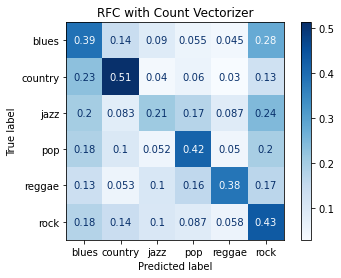

In [37]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_rfc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("RFC with Count Vectorizer");

In [38]:
pipe_tfv_rfc = Pipeline([
    ('tfv',TfidfVectorizer()),
    ('rfc', RandomForestClassifier())
])

#fit
pipe_tfv_rfc.fit(X_train,y_train)
pipe_tfv_rfc.score(X_train, y_train), pipe_tfv_rfc.score(X_test,y_test)

(1.0, 0.38564273789649417)

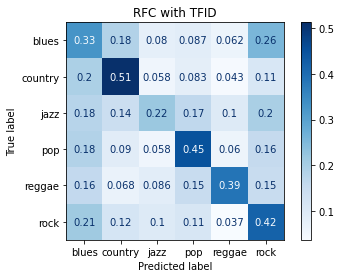

In [39]:
ConfusionMatrixDisplay.from_estimator(pipe_tfv_rfc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("RFC with TFID");

In [40]:
pipe_cv_svm = Pipeline([
    ('cv',CountVectorizer()),
    ('svm', svm.SVC(C=1.0, kernel='linear', random_state=42))]
)

pipe_cv_svm.fit(X_train,y_train)
pipe_cv_svm.score(X_train,y_train), pipe_cv_svm.score(X_test,y_test)

(0.9988520141932791, 0.34557595993322204)

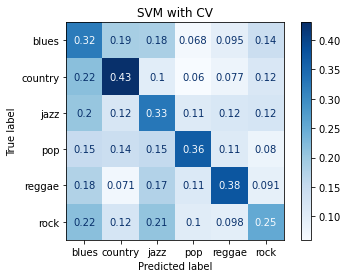

In [41]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_svm, X_test, y_test, cmap="Blues", normalize='true')
plt.title("SVM with CV");

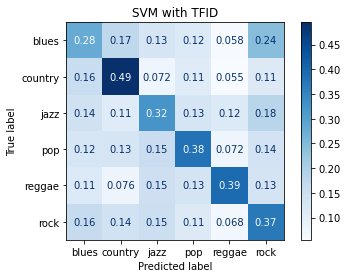

In [44]:
pipe_tfv_svm = Pipeline([
    ('cv',TfidfVectorizer()),
    ('svm', svm.SVC(C=1.0, kernel='linear', random_state=42))]
)

pipe_tfv_svm.fit(X_train,y_train)
pipe_tfv_svm.score(X_train,y_train), pipe_tfv_svm.score(X_test,y_test)
ConfusionMatrixDisplay.from_estimator(pipe_tfv_svm, X_test, y_test, cmap="Blues", normalize='true')
plt.title("SVM with TFID");

In [43]:
pipe_cv_dtc = Pipeline([
    ('cv',CountVectorizer()),
    ('dtc', DecisionTreeClassifier(random_state=42))]
)

pipe_cv_dtc.fit(X_train,y_train)
pipe_cv_dtc.score(X_train,y_train), pipe_cv_dtc.score(X_test,y_test)

(1.0, 0.2541736227045075)

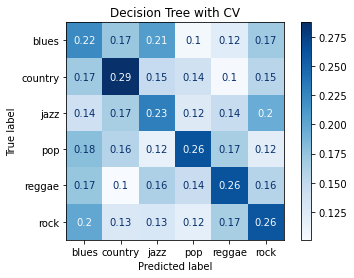

In [45]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_dtc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Decision Tree with CV");

In [46]:
pipe_tfid_dtc = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('dtc', DecisionTreeClassifier(random_state=42))]
)

pipe_tfid_dtc.fit(X_train,y_train)
pipe_tfid_dtc.score(X_train,y_train), pipe_tfid_dtc.score(X_test,y_test)

(1.0, 0.2696160267111853)

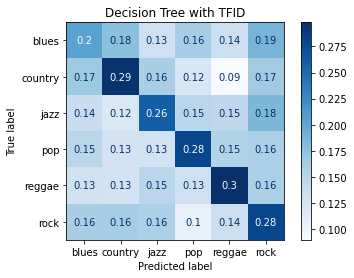

In [47]:
ConfusionMatrixDisplay.from_estimator(pipe_tfid_dtc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Decision Tree with TFID");

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, stratify=y)
y_train.value_counts()

jazz       1600
rock       1600
blues      1600
country    1600
pop        1600
reggae     1582
Name: genre, dtype: int64

In [49]:
oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_over, y_over = oversample.fit_resample(pd.DataFrame(X_train), y_train)
y_over.value_counts()

jazz       1600
reggae     1600
rock       1600
blues      1600
country    1600
pop        1600
Name: genre, dtype: int64

In [50]:
pipe_cv_rfc_os = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))
])

#fit
X_over = X_over.squeeze()
pipe_cv_rfc_os.fit(X_over,y_over)
pipe_cv_rfc_os.score(X_over, y_over), pipe_cv_rfc_os.score(X_test,y_test)

(1.0, 0.3885642737896494)

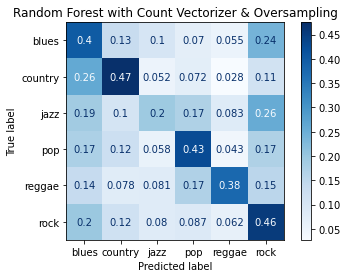

In [53]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_rfc_os, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Random Forest with Count Vectorizer & Oversampling");
plt.savefig('Lyrics_RFC_CV_OS.jpeg')

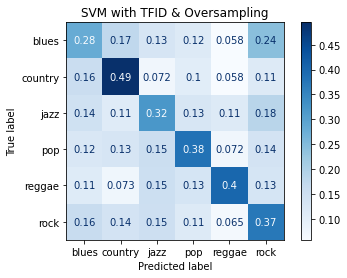

In [55]:
pipe_tfv_svm_os = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('svm', svm.SVC(C=1.0, kernel='linear', random_state=42))]
)

pipe_tfv_svm_os.fit(X_over,y_over)
pipe_tfv_svm_os.score(X_over,y_over), pipe_tfv_svm_os.score(X_test,y_test)
ConfusionMatrixDisplay.from_estimator(pipe_tfv_svm_os, X_test, y_test, cmap="Blues", normalize='true')
plt.title("SVM with TFID & Oversampling");
plt.savefig('Lyrics_SVM_TFID_OS.jpeg')

In [82]:
get_metrics("Random Forest with CountVect & Oversampling", pipe_cv_rfc, X, y, True)

,model,oversampling,train_accuracy,accuracy,blues,country,jazz,pop,reggae,rock
0,Random Forest with CountVect & Oversampling,True,1.0,0.388564,0.4,0.475,0.195,0.4275,0.378788,0.455


In [83]:
results = pd.concat([get_metrics("Random Forest with CountVectorizer", pipe_cv_rfc, X, y),
           get_metrics("Random Forest with CountVectorizer", pipe_cv_rfc, X, y, True),
           get_metrics("Random Forest with TFID", pipe_tfv_rfc, X, y),
           get_metrics("Random Forest with TFID", pipe_tfv_rfc, X, y, True),
           get_metrics("Decision Tree with CountVectorizer", pipe_cv_dtc, X, y),
           get_metrics("SVM with CountVectorizer", pipe_cv_svm, X, y),
           get_metrics("SVM with CountVectorizer", pipe_cv_svm, X, y, True),
           get_metrics("SVM with TFID", pipe_tfv_svm, X, y),
           get_metrics("SVM with TFID", pipe_tfv_svm, X, y, True)
          ]
         )
results

,model,oversampling,train_accuracy,accuracy,blues,country,jazz,pop,reggae,rock
0,Random Forest with CountVectorizer,False,1.000000,0.391486,0.3900,0.5125,0.2100,0.4175,0.383838,0.4350
0,Random Forest with CountVectorizer,True,1.000000,0.388564,0.4000,0.4750,0.1950,0.4275,0.378788,0.4550
0,Random Forest with TFID,False,1.000000,0.375209,0.3075,0.5325,0.1550,0.4425,0.396465,0.4175
0,Random Forest with TFID,True,1.000000,0.387312,0.3700,0.4975,0.2250,0.4150,0.414141,0.4025
0,Decision Tree with CountVectorizer,False,1.000000,0.254174,0.2225,0.2875,0.2300,0.2625,0.262626,0.2600
0,SVM with CountVectorizer,False,0.998852,0.345576,0.3225,0.4300,0.3275,0.3650,0.376263,0.2525
0,SVM with CountVectorizer,True,0.998854,0.345576,0.3225,0.4300,0.3275,0.3650,0.376263,0.2525
0,SVM with TFID,False,0.728136,0.373957,0.2800,0.4950,0.3225,0.3825,0.393939,0.3700
0,SVM with TFID,True,0.728021,0.375209,0.2800,0.4950,0.3200,0.3825,0.401515,0.3725


In [84]:
results.to_csv('model_results_lyrics.csv')